In [1]:
%matplotlib inline
import os
import math
import dgl
import dgl.function as fn
from dgl import DGLGraph
from collections import namedtuple
import networkx as nx
import torch
import torch.nn.functional as F
from torch.nn.functional import cosine_similarity
import torch.optim as optim
import torch.nn as nn
from torch.nn import Linear
import numpy as np
import pandas as pd
from torch_geometric.data import Data, Batch
from torch_geometric.nn.conv import GCNConv
from rdkit import Chem
from rdkit import DataStructs
from rdkit.Chem import AllChem, Draw, DataStructs, RDConfig
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem.rdmolops import GetAdjacencyMatrix, Get3DDistanceMatrix
from rdkit.Chem.Descriptors import rdMolDescriptors
from sklearn.preprocessing import normalize
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from e3fp.fingerprint.generate import fp, fprints_dict_from_mol
from e3fp.conformer.generate import generate_conformers
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Dataset, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.decomposition import PCA
import seaborn as sns
from sklearn.metrics import roc_curve
from sklearn import metrics
IPythonConsole.ipython_useSVG=True


In [2]:
# 判断是用GPU或CPU计算
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [3]:
df = pd.read_csv('./dataset/BindingDB_PubChem_3D_dataset.csv')
df_E3FPTC = pd.read_csv('./dataset/BindingDB_PubChem_3D_E3FPTC_dataset.csv')
df_E3FP_features = pd.read_csv('./dataset/BindingDB_PubChem_3D_E3FP_features_dataset.csv')
df_E3FP_features

c:\Users\khooz\anaconda3\envs\py37\lib\site-packages\IPython\core\interactiveshell.py:3457: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,0,1,2,3,4,5,6,7,8,9,...,30,31,32,33,34,35,36,37,38,39
0,-0.983263,-1.166415,-1.249350,-1.068665,-1.121721,-1.117055,-1.224719,-1.318566,-1.334739,-1.354728,...,-0.952645,-0.894574,-0.820113,-0.757948,-0.637069,-0.521086,-0.376068,-0.286228,-0.257705,-0.219803
1,0.666180,-0.139333,-0.572288,-0.776188,-0.380813,-0.243780,-0.463091,-0.615963,-0.366295,-0.061799,...,0.769443,0.800485,0.792855,1.228167,1.261532,1.256266,1.222668,1.273558,1.253747,1.284284
2,0.776802,-0.103565,-0.487509,0.200332,0.000140,-0.199194,0.797119,0.699588,0.984345,1.715953,...,0.606610,0.621580,1.157749,1.181641,1.181323,1.256266,1.212814,1.366578,1.392819,-1.857813
3,-0.814780,0.360073,1.014775,2.866864,2.214848,1.820492,2.237551,2.078685,1.829508,1.505280,...,0.568903,0.546820,0.635814,0.668668,0.642201,0.616973,0.689321,0.842625,0.913798,1.119468
4,-0.983263,-1.166415,-1.055047,-0.662135,-0.719383,-0.342899,-0.496693,-0.539112,-0.662968,-0.823325,...,-0.208676,-0.147735,-0.032420,-0.044783,-0.063611,-0.057735,0.055395,0.177449,0.227949,0.255099
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2007,1.307484,0.271001,0.060777,-0.195164,-0.042526,-0.268379,-0.437173,-0.586041,-0.455469,-0.623251,...,-0.233504,-0.219527,-0.194399,-0.179186,-0.152994,-0.128679,-0.034183,0.026991,0.066381,0.127233
2008,0.216373,0.309298,-0.047804,0.576023,0.359213,0.918007,1.136080,0.992557,0.946277,1.115922,...,-3.091313,-2.924475,-2.747352,-2.658895,-2.558946,-2.421611,-2.249812,-2.053875,-1.952967,-1.857813
2009,-0.067137,-0.126354,-0.047804,-0.337955,-0.115503,-0.342899,-0.437173,0.891096,1.123276,0.920968,...,0.544095,0.503296,0.486876,1.116919,1.110175,1.236432,1.313879,-2.053875,-1.952967,-1.857813
2010,0.064027,-0.255797,-0.478995,-0.448674,0.021305,-0.268379,-0.463091,-0.185950,-0.357690,-0.086614,...,0.063110,0.118103,0.141506,0.102027,0.116815,0.162417,0.316294,0.386437,0.400281,0.509089


In [4]:
df

,mol_name,smiles,mol_weight,IC50 (nM)
0,644735,[H]N=c1c(C(=O)N([H])C([H])([H])c2oc([H])c([H])...,0.656075,0.484091
1,649963,[H]c1c(OC([H])([H])[H])c([H])c2c([H])c(C#N)c(N...,0.355214,0.578407
2,652912,[H]OC(=O)C1([H])N([H])c2c(OC([H])([H])[H])c([H...,0.337642,0.484418
3,5295075,[H]c1c([H])c([H])c2c(c1[H])-c1c([H])c(C([H])([...,0.455525,0.578407
4,656318,[H]N=c1c(S(=O)(=O)c2c([H])c([H])c([H])c([H])c2...,0.647206,0.550605
...,...,...,...,...
2007,1113907,[H]c1nn2c(C(F)(F)F)c([H])c(-c3c([H])c([H])c(C(...,0.605228,0.552031
2008,794007,[H]c1c([H])c([H])c(C([H])([H])N([H])c2c([H])c(...,0.256089,0.629854
2009,879257,[H]c1c(OC(=O)C([H])([H])C([H])([H])[H])c(C([H]...,0.339829,0.517832
2010,1124527,[H]c1c([H])c(-c2nc3c([H])c(C(=O)N4C([H])([H])C...,0.574342,0.546494


In [5]:
df_E3FPTC

,MOLI,MOLJ,E3FPTC,i,j
0,649963,644735,0.063636,1,0
1,652912,644735,0.084906,2,0
2,652912,649963,0.159420,2,1
3,5295075,644735,0.073394,3,0
4,5295075,649963,0.093333,3,1
...,...,...,...,...,...
2023061,824943,828565,0.101124,2011,2006
2023062,824943,1008368,0.113402,2011,2007
2023063,824943,5219869,0.103448,2011,2008
2023064,824943,1480155,0.115942,2011,2009


In [6]:
df_E3FPTC.shape

(2023066, 5)

In [7]:
# 构建邻接矩阵
# 把邻接矩阵转COO格式的图连接
# 显示i和j之间右有边，用[i, j]表示
# 是pyg Data类的edge_index邻接矩阵表示
adj = []
for i in range(df_E3FPTC.shape[0]):
    adj.append([df_E3FPTC['i'][i], df_E3FPTC['j'][i]])
adj

[[1, 0],
 [2, 0],
 [2, 1],
 [3, 0],
 [3, 1],
 [3, 2],
 [4, 0],
 [4, 1],
 [4, 2],
 [4, 3],
 [5, 0],
 [5, 1],
 [5, 2],
 [5, 3],
 [5, 4],
 [6, 0],
 [6, 1],
 [6, 2],
 [6, 3],
 [6, 4],
 [6, 5],
 [7, 0],
 [7, 1],
 [7, 2],
 [7, 3],
 [7, 4],
 [7, 5],
 [7, 6],
 [8, 0],
 [8, 1],
 [8, 2],
 [8, 3],
 [8, 4],
 [8, 5],
 [8, 6],
 [8, 7],
 [9, 0],
 [9, 1],
 [9, 2],
 [9, 3],
 [9, 4],
 [9, 5],
 [9, 6],
 [9, 7],
 [9, 8],
 [10, 0],
 [10, 1],
 [10, 2],
 [10, 3],
 [10, 4],
 [10, 5],
 [10, 6],
 [10, 7],
 [10, 8],
 [10, 9],
 [11, 0],
 [11, 1],
 [11, 2],
 [11, 3],
 [11, 4],
 [11, 5],
 [11, 6],
 [11, 7],
 [11, 8],
 [11, 9],
 [11, 10],
 [12, 0],
 [12, 1],
 [12, 2],
 [12, 3],
 [12, 4],
 [12, 5],
 [12, 6],
 [12, 7],
 [12, 8],
 [12, 9],
 [12, 10],
 [12, 11],
 [13, 0],
 [13, 1],
 [13, 2],
 [13, 3],
 [13, 4],
 [13, 5],
 [13, 6],
 [13, 7],
 [13, 8],
 [13, 9],
 [13, 10],
 [13, 11],
 [13, 12],
 [14, 0],
 [14, 1],
 [14, 2],
 [14, 3],
 [14, 4],
 [14, 5],
 [14, 6],
 [14, 7],
 [14, 8],
 [14, 9],
 [14, 10],
 [14, 11],
 [14, 1

In [8]:
class GCN(nn.Module):
    def __init__(self, in_features, hidden_features, num_classes):
        super(GCN, self).__init__()
        self.gc1 = GCNConv(in_features, hidden_features)
        self.gc2 = GCNConv(hidden_features, num_classes)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.3)

    def forward(self, data):
        x, edge_index, edge_weight = data.x, data.edge_index, data.edge_attr
        x = self.gc1(x, edge_index, edge_weight)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.gc2(x, edge_index, edge_weight)
        return F.log_softmax(x, dim=1)

In [9]:
concat_x = pd.concat([df_E3FP_features, pd.DataFrame(df['mol_weight'])], axis=1)
concat_x

,0,1,2,3,4,5,6,7,8,9,...,31,32,33,34,35,36,37,38,39,mol_weight
0,-0.983263,-1.166415,-1.249350,-1.068665,-1.121721,-1.117055,-1.224719,-1.318566,-1.334739,-1.354728,...,-0.894574,-0.820113,-0.757948,-0.637069,-0.521086,-0.376068,-0.286228,-0.257705,-0.219803,0.656075
1,0.666180,-0.139333,-0.572288,-0.776188,-0.380813,-0.243780,-0.463091,-0.615963,-0.366295,-0.061799,...,0.800485,0.792855,1.228167,1.261532,1.256266,1.222668,1.273558,1.253747,1.284284,0.355214
2,0.776802,-0.103565,-0.487509,0.200332,0.000140,-0.199194,0.797119,0.699588,0.984345,1.715953,...,0.621580,1.157749,1.181641,1.181323,1.256266,1.212814,1.366578,1.392819,-1.857813,0.337642
3,-0.814780,0.360073,1.014775,2.866864,2.214848,1.820492,2.237551,2.078685,1.829508,1.505280,...,0.546820,0.635814,0.668668,0.642201,0.616973,0.689321,0.842625,0.913798,1.119468,0.455525
4,-0.983263,-1.166415,-1.055047,-0.662135,-0.719383,-0.342899,-0.496693,-0.539112,-0.662968,-0.823325,...,-0.147735,-0.032420,-0.044783,-0.063611,-0.057735,0.055395,0.177449,0.227949,0.255099,0.647206
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2007,1.307484,0.271001,0.060777,-0.195164,-0.042526,-0.268379,-0.437173,-0.586041,-0.455469,-0.623251,...,-0.219527,-0.194399,-0.179186,-0.152994,-0.128679,-0.034183,0.026991,0.066381,0.127233,0.605228
2008,0.216373,0.309298,-0.047804,0.576023,0.359213,0.918007,1.136080,0.992557,0.946277,1.115922,...,-2.924475,-2.747352,-2.658895,-2.558946,-2.421611,-2.249812,-2.053875,-1.952967,-1.857813,0.256089
2009,-0.067137,-0.126354,-0.047804,-0.337955,-0.115503,-0.342899,-0.437173,0.891096,1.123276,0.920968,...,0.503296,0.486876,1.116919,1.110175,1.236432,1.313879,-2.053875,-1.952967,-1.857813,0.339829
2010,0.064027,-0.255797,-0.478995,-0.448674,0.021305,-0.268379,-0.463091,-0.185950,-0.357690,-0.086614,...,0.118103,0.141506,0.102027,0.116815,0.162417,0.316294,0.386437,0.400281,0.509089,0.574342


In [10]:
mol_weight = torch.tensor(df['mol_weight'].values.astype(float), dtype=torch.float)
ic50 = torch.tensor(df['IC50 (nM)'].values.astype(float), dtype=torch.float)
mol_weight

tensor([0.6561, 0.3552, 0.3376,  ..., 0.3398, 0.5743, 0.4163])

In [11]:
edge_index = torch.tensor(adj, dtype=torch.long)
edge_index

tensor([[   1,    0],
        [   2,    0],
        [   2,    1],
        ...,
        [2011, 2008],
        [2011, 2009],
        [2011, 2010]])

In [12]:
edge_attr = torch.tensor(df_E3FPTC['E3FPTC'].values.astype(float), dtype=torch.float)
edge_attr

tensor([0.0636, 0.0849, 0.1594,  ..., 0.1034, 0.1159, 0.1163])

In [13]:
x = torch.tensor(concat_x.values.astype(float), dtype=torch.float)
x.shape

torch.Size([2012, 41])

In [14]:
# 标签
y = ic50
y.shape

torch.Size([2012])

In [15]:
# 转成pyg Data类可接受的数据格式
edge_index = edge_index.t().contiguous()
edge_index

tensor([[   1,    2,    2,  ..., 2011, 2011, 2011],
        [   0,    0,    1,  ..., 2008, 2009, 2010]])

In [16]:
x_len = x.shape[0]
# 训练集占80%，测试集占10%，验证集占10%，随机划分
train_idx = np.random.choice(x_len, int(0.8 * x_len), replace=False)
train_mask = torch.zeros(x_len, dtype=torch.bool)
train_mask[train_idx] = 1

test_idx = np.random.choice(x_len, int(0.1 * x_len), replace=False)
test_mask = torch.zeros(x_len, dtype=torch.bool)
test_mask[test_idx] = 1

val_mask = torch.zeros(x_len, dtype=torch.bool)
val_mask[~train_mask & ~test_mask] = 1

train_mask, val_mask, test_mask

(tensor([ True,  True,  True,  ..., False,  True,  True]),
 tensor([False, False, False,  ...,  True, False, False]),
 tensor([False, False, False,  ..., False, False, False]))

In [17]:
train_mask.shape, test_mask.shape, val_mask.shape

(torch.Size([2012]), torch.Size([2012]), torch.Size([2012]))

In [18]:
data = Data(x=x, y=y,edge_index=edge_index, edge_attr=edge_attr,
            train_mask=train_mask, test_mask=test_mask, val_mask=val_mask)

In [19]:
print(data)
print(data.is_directed())
print(data.has_self_loops())
print(data.has_isolated_nodes())
print(data.num_nodes)
print(data.num_edges)
print(data.num_node_features)
print(data.num_edge_features)

Data(x=[2012, 41], edge_index=[2, 2023066], edge_attr=[2023066], y=[2012], train_mask=[2012], test_mask=[2012], val_mask=[2012])
True
False
False
2012
2023066
41
1


In [20]:
# 选择模型，加入输入特征维度，隐藏层维度，输出维度
model = GCN(in_features=data.num_features, hidden_features=512, num_classes=2).to(device)
# 选择优化器，加入学习率lr，
# 当lr过小->收敛下降过慢，过大->错过局部最优；
# 加入正则化系数weight_decay，防止过拟合
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

epochs = 50

In [21]:
# 训练模型
def train(model, data, mask):
    model.train()
    optimizer.zero_grad()
    output = model(data)
    loss = F.nll_loss(output[mask], data.y[mask].long())
    loss.backward()
    optimizer.step()
    return loss.item()

In [22]:
# 评估函数
def evaluate(model, data, mask):
    model.eval()
    with torch.no_grad():
        y_pred = model(data)
        y_true = data.y
        # 转换 y_pred 的形状使其符合 y_true
        y_pred = y_pred[:, 0] 

        mae = mean_absolute_error(y_true[mask], y_pred[mask])
        rmse = math.sqrt(mean_squared_error(y_true[mask], y_pred[mask]))
        
    return rmse, mae

In [23]:
train_losses = []

val_rmse_list = []
test_rmse_list = []
val_mae_list = []
test_mae_list = []

In [24]:

for epoch in range(1, epochs + 1):
    train_loss = train(model, data, data.train_mask)
    train_losses.append(train_loss)

    val_rmse, val_mae = evaluate(model, data, data.val_mask)
    val_rmse_list.append(val_rmse)
    val_mae_list.append(val_mae)
    
    test_rmse, test_mae = evaluate(model, data, data.test_mask)
    test_rmse_list.append(test_rmse)
    test_mae_list.append(test_mae)

    if epoch % 5 == 0:
        print('Epoch {:03d} ———— Train Loss: {:.4f}'.format(epoch, train_losses[-1]))
        print('Val RMSE: {:.4f}'.format(val_rmse_list[-1]))
        print('Test RMSE: {:.4f}'.format(test_rmse_list[-1]))
        print('Val MAE: {:.4f}'.format(val_mae_list[-1]))
        print('Test MAE: {:.4f}'.format(test_mae_list[-1]))

    

Epoch 005 ———— Train Loss: 0.2261
Val RMSE: 0.6304
Test RMSE: 0.6410
Val MAE: 0.6214
Test MAE: 0.6317
Epoch 010 ———— Train Loss: 0.0523
Val RMSE: 0.5072
Test RMSE: 0.5145
Val MAE: 0.4973
Test MAE: 0.5049
Epoch 015 ———— Train Loss: 0.0177
Val RMSE: 0.4813
Test RMSE: 0.4857
Val MAE: 0.4716
Test MAE: 0.4768
Epoch 020 ———— Train Loss: 0.0073
Val RMSE: 0.4742
Test RMSE: 0.4772
Val MAE: 0.4646
Test MAE: 0.4687
Epoch 025 ———— Train Loss: 0.0042
Val RMSE: 0.4718
Test RMSE: 0.4740
Val MAE: 0.4622
Test MAE: 0.4656
Epoch 030 ———— Train Loss: 0.0027
Val RMSE: 0.4707
Test RMSE: 0.4725
Val MAE: 0.4612
Test MAE: 0.4642
Epoch 035 ———— Train Loss: 0.0020
Val RMSE: 0.4702
Test RMSE: 0.4717
Val MAE: 0.4607
Test MAE: 0.4635
Epoch 040 ———— Train Loss: 0.0017
Val RMSE: 0.4699
Test RMSE: 0.4713
Val MAE: 0.4604
Test MAE: 0.4631
Epoch 045 ———— Train Loss: 0.0014
Val RMSE: 0.4697
Test RMSE: 0.4710
Val MAE: 0.4602
Test MAE: 0.4628
Epoch 050 ———— Train Loss: 0.0013
Val RMSE: 0.4696
Test RMSE: 0.4708
Val MAE: 0.46

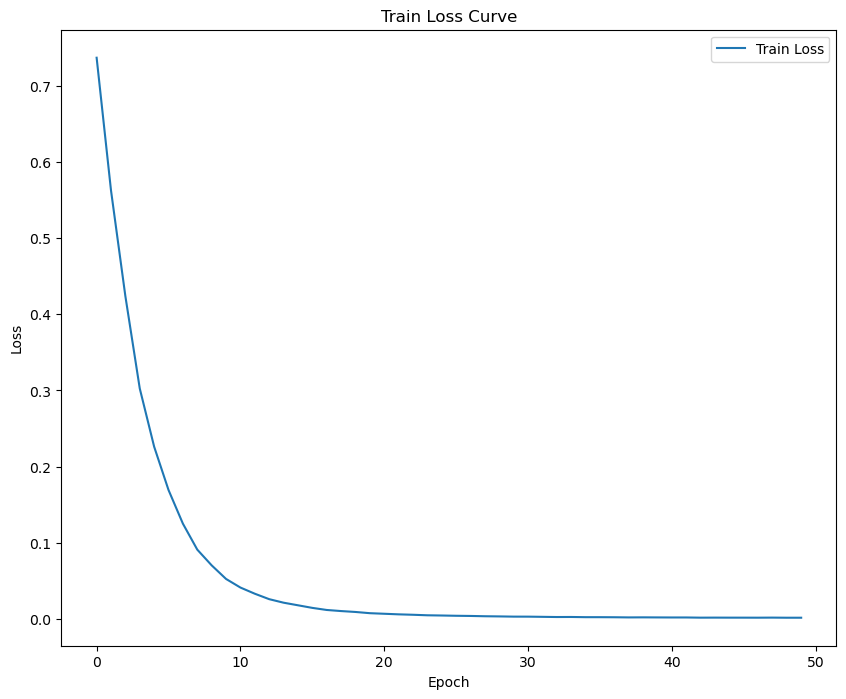

In [25]:
# 画图
plt.figure(figsize=(10, 8))
plt.plot(train_losses, label='Train Loss')
# 添加x轴标签
plt.xlabel('Epoch')
# 添加y轴标签
plt.ylabel('Loss')
# 添加title
plt.title('Train Loss Curve')
plt.legend()
plt.show()

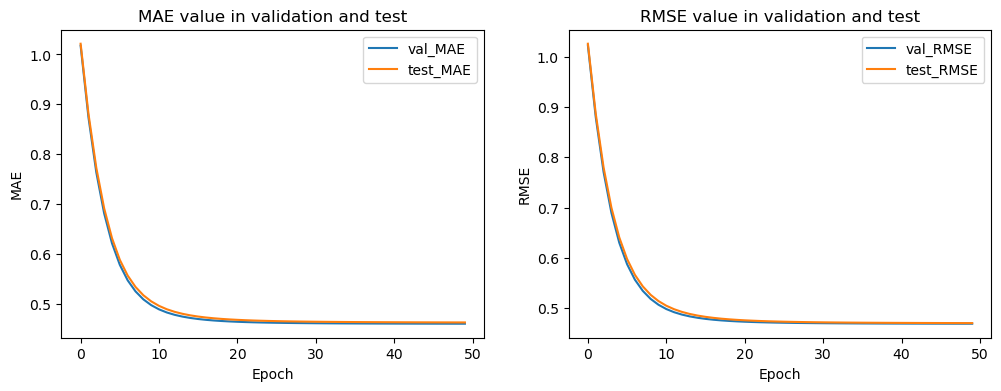

In [26]:
# 训练损失和验证损失图像
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# 图表示MAE
ax1.plot(np.arange(len(val_mae_list)), val_mae_list, label='val_MAE')
ax1.plot(np.arange(len(test_mae_list)), test_mae_list, label='test_MAE')
ax1.set_title('MAE value in validation and test')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('MAE')
ax1.legend()

# 图表示RMSE
ax2.plot(np.arange(len(val_rmse_list)), val_rmse_list, label='val_RMSE')
ax2.plot(np.arange(len(test_rmse_list)), test_rmse_list, label='test_RMSE')
ax2.set_title('RMSE value in validation and test')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('RMSE')
ax2.legend()

plt.show()